# Prelim GLM-Spectrum analyses for COINS-MEG

##### Last edited AXL 3/11/23

This notebook replicates the preliminary GLM-spectrum analyses outlined during the OSL workshop, but on a single run from the COINS-MEG task. 

In [4]:
import numpy as np
from scipy import signal
import osl
import os
import sails
import glmtools as glm
import mne
from pprint import pprint

import matplotlib
font = {'size' : '18'}

matplotlib.rc('font', **font)
import matplotlib.pyplot as plt

In [5]:
basedir = '/Volumes/external-drive/work-data/coins-meg_meg-analysis/'
subj = 14
run = 2

# Set directory paths
procdir = os.path.join(basedir, 'preprocessed') # directory for the processed data

preproc_fname = os.path.join(procdir, 'auto-max', f'sub-{subj}_ses-2-meg_task-coinsmeg_run-{run}_meg_transsss',
                                    f'sub-{subj}_ses-2-meg_task-coinsmeg_run-{run}_meg_transsss_preproc_raw.fif')

# Now actually read in the preprocessed and ica data
clean = mne.io.read_raw_fif(preproc_fname, preload=True)

Opening raw data file /Volumes/external-drive/work-data/coins-meg_meg-analysis/preprocessed/auto-max/auto-max/sub-14_ses-2-meg_task-coinsmeg_run-2_meg_transsss/sub-14_ses-2-meg_task-coinsmeg_run-2_meg_transsss_preproc_raw.fif...
    Range : 59000 ... 871999 =     59.000 ...   871.999 secs
Ready.
Reading 0 ... 812999  =      0.000 ...   812.999 secs...


In [6]:
# Extract and filter the EOG - we'll use this later...
eogs = clean.copy().pick_types(meg=False, eog=True)
eogs = eogs.filter(l_freq=3, h_freq=20, picks='eog').get_data() 

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 sec)



In [7]:
# Extract only the gradiometers
clean = clean.copy().pick_types(meg='grad')

# Remove headshape points - none were recorded on the back of the head and this distorts our topoplots
mon = clean.get_montage()
mon.dig = [dd for dd in mon.dig if dd['kind'] < 4]
clean = clean.set_montage(mon)

In [8]:
# Compute standard spectrum using Welch's method

# Truncate the spectrum to values between 1.5Hz and 95Hz to clip parts of the spectrum that have been affected by bandpass filtering during preprocessing
glmspec1 = osl.glm.glm_spectrum(clean, fmin=1.5, fmax=95)

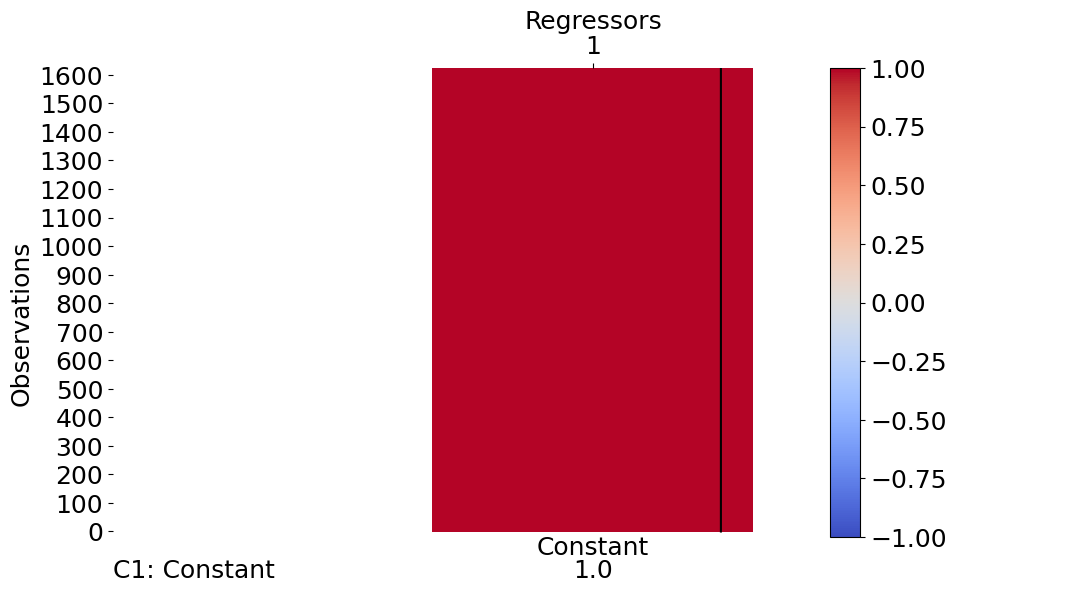

In [9]:
# Look at design matrix to see if expected
fig = glmspec1.design.plot_summary()

In [10]:
glmspec1.info

<Info | 24 non-empty values
 acq_pars: ACQactiveGround 1 ACQch.BIO001.gain 2000 ACQch.BIO001.highpass ...
 bads: []
 ch_names: MEG0112, MEG0113, MEG0122, MEG0123, MEG0132, MEG0133, MEG0142, ...
 chs: 204 Gradiometers
 custom_ref_applied: False
 description: TRIUX system at OHBA-3143 OSL BATCH PROCESSING APPLIED ON ...
 dev_head_t: MEG device -> head transform
 dig: 8 items (3 Cardinal, 5 HPI)
 events: 1 item (list)
 experimenter: ali (ali)
 file_id: 4 items (dict)
 gantry_angle: 68.0
 highpass: 0.2 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 2 items (dict)
 line_freq: 50.0
 lowpass: 100.0 Hz
 meas_date: 2023-05-05 14:08:25 UTC
 meas_id: 4 items (dict)
 nchan: 204
 proc_history: 2 items (list)
 proj_id: 1 item (ndarray)
 proj_name: coins_mmxxii_cx
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 4 items (dict)
>

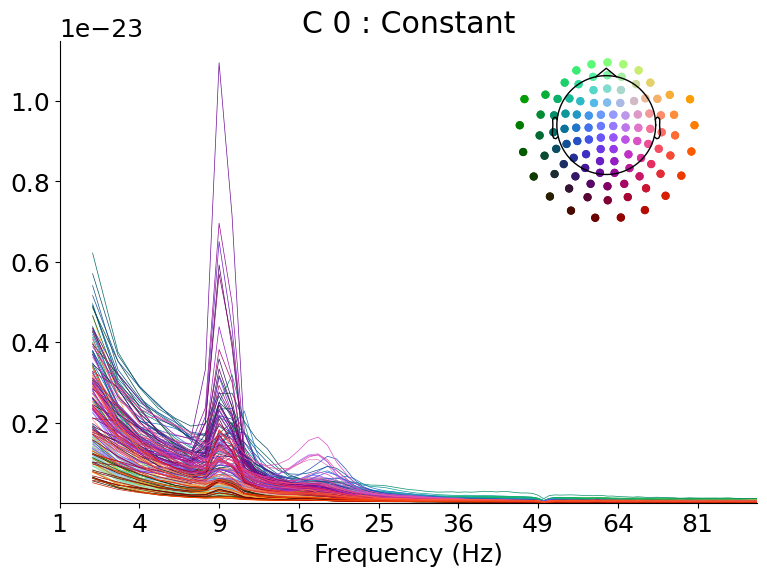

In [11]:
# Plot power spectrum
plt.figure(figsize=(9,6))
ax = plt.subplot(111)
glmspec1.plot_sensor_spectrum(0, ax=ax, sensor_proj=True, base=0.5)

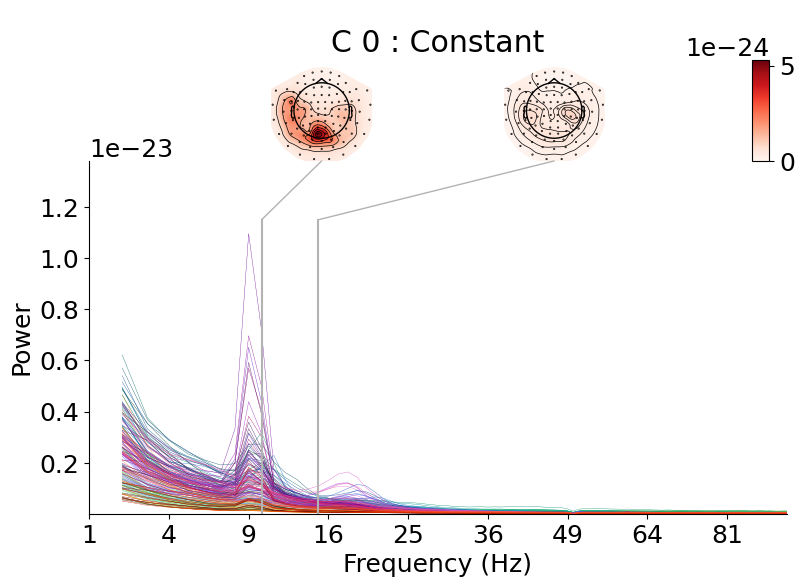

In [12]:
plt.figure(figsize=(9,6))
ax = plt.subplot(111)
glmspec1.plot_joint_spectrum(freqs=[10.5, 15], base=0.5, ax=ax)

In [13]:
# Explore GLM-Spectrum

# defining three additional regressors to add into our model. One zero-mean covariate that quantifies a linear trend in time
# and two non-zero-mean confound regressors that quantify the effect of the EOG channel and the bad segments identified in the dataset.

# Compute a time-series indicating where bad segments appear in the data
bads = np.zeros((clean.n_times,))
for an in clean.annotations:
    if an['description'].startswith('bad'):
        start = clean.time_as_index(an['onset'])[0] - clean.first_samp
        duration = int(an['duration'] * clean.info['sfreq'])
        bads[start:start+duration] = 1

# Define dictionaries containing the covariate terms
covs = {'Linear': np.linspace(0, 1, clean.times.shape[0])}
cons = {'EOG': np.abs(eogs)[1, :],
        'BadSegs': bads}

# Compute the GLM-Spectrum
glmspec2 = osl.glm.glm_spectrum(clean, fmin=1.5, fmax=95, reg_ztrans=covs, reg_unitmax=cons)

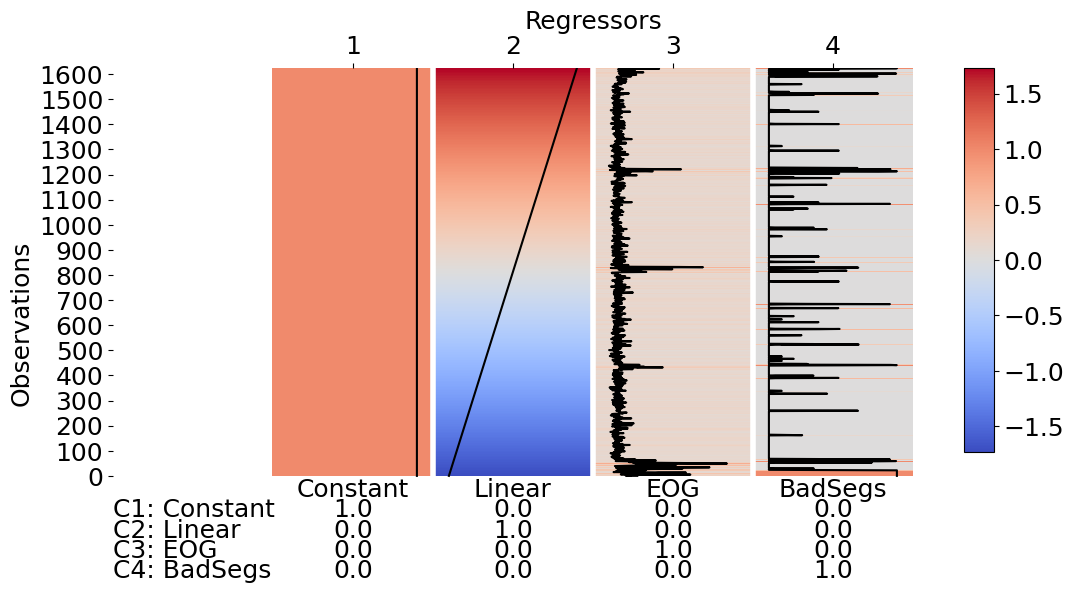

In [14]:
# Check design matrix
fig = glmspec2.design.plot_summary()

Our four regressors are present as expected. Note that only the 'Linear' regressor contains any negative values.

We should also check the y-axis labels here to see the number of observations going into our model fit. This corresponds to the number of sliding window data segments computed in our Short-Time Fourier Transform. 

Let's take a look at the GLM cope-spectra for each of the four contrasts. We'll use `plot_joint_spectrum` to visualise both the spectrum and the topography of the spectrum at a few key frequencies.

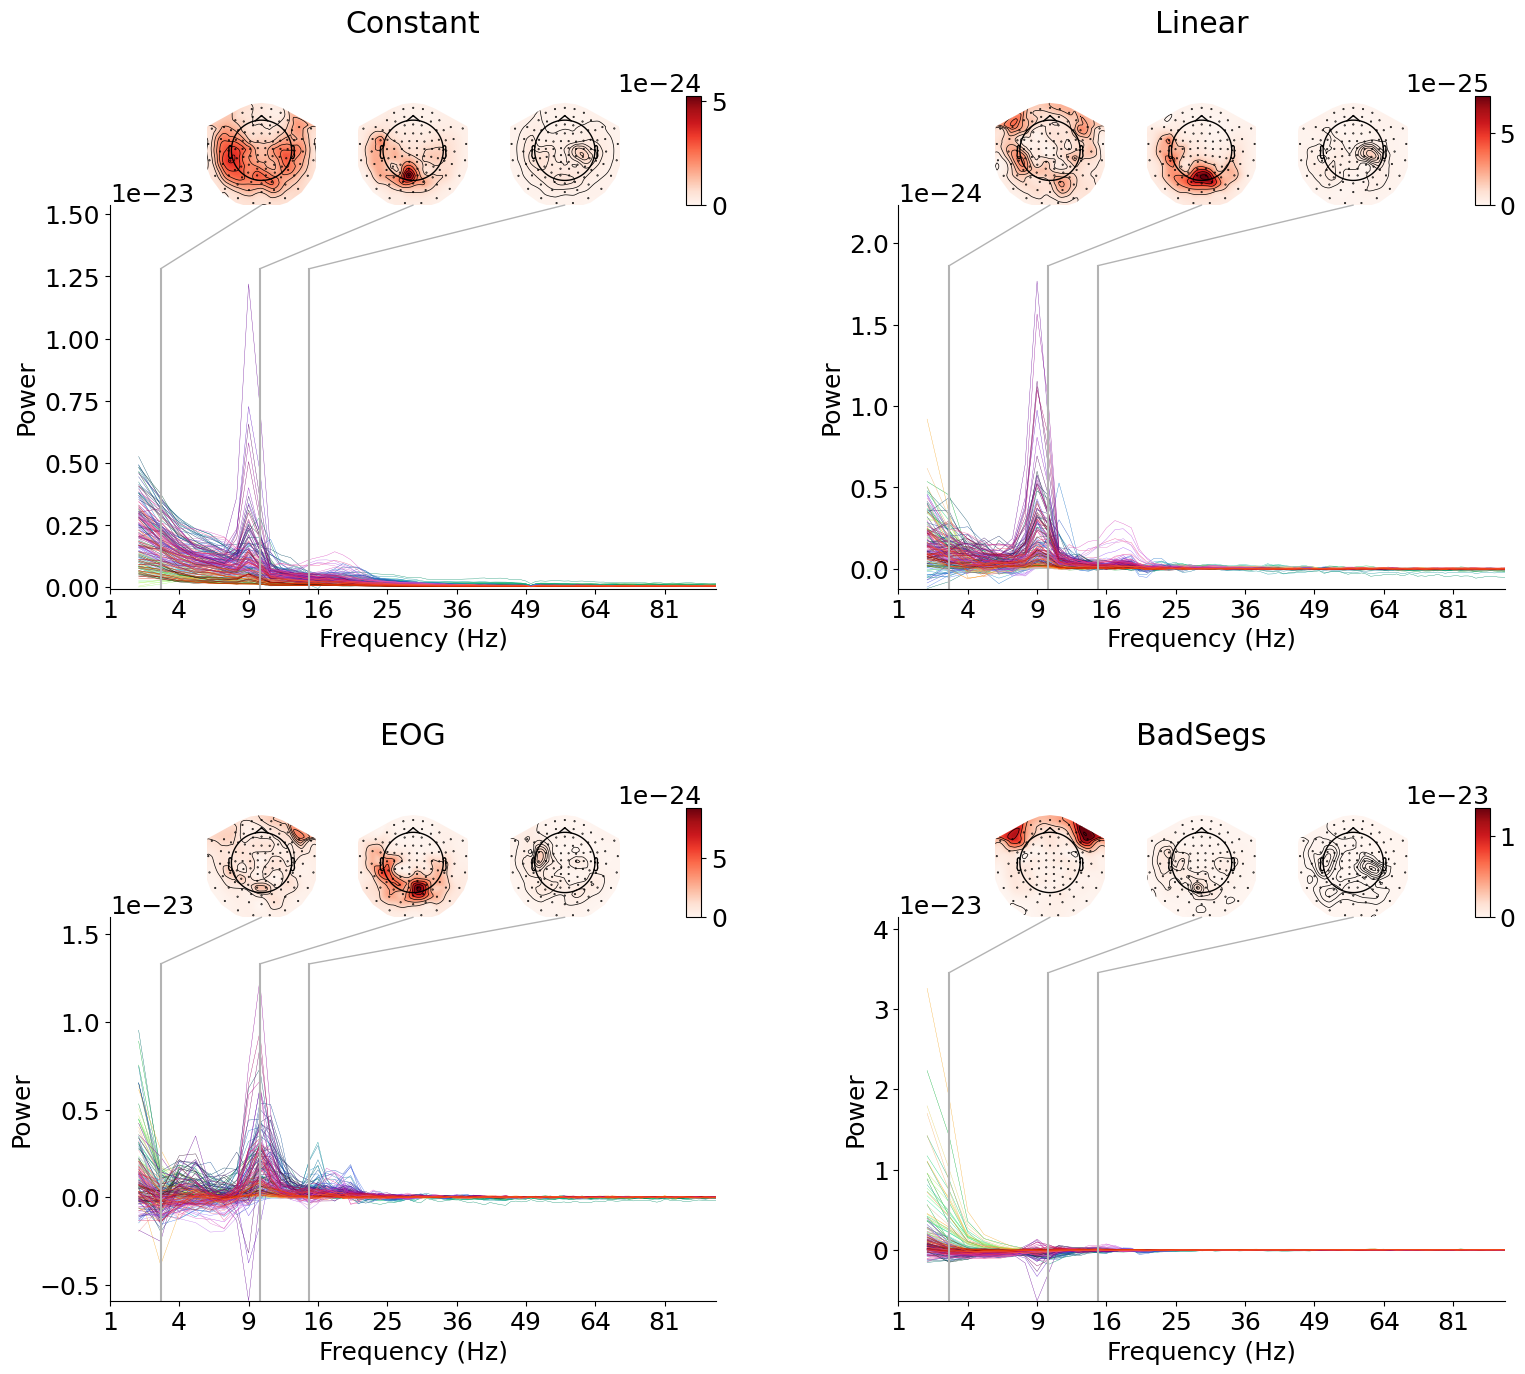

In [15]:
plt.figure(figsize=(18,15))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

for ii in range(4):
    ax = plt.subplot(2, 2, ii+1)
    glmspec2.plot_joint_spectrum(contrast=ii, freqs=[3, 10, 15], ax=ax, base=0.5)
    plt.title(glmspec2.design.contrast_names[ii])

 - The 'Mean' spectrum corresponds to our constant regressor (though this actually computes an intercept as we've included other non-zero regressors in the model).
 
 - The 'Linear' regressor has a positive peak around 9Hz which appears centered around occipital cortex. This suggests that occipital alpha power is increasing over time during the data recording.
 
 - The 'EOG' confound regressor has large values at low frequencies around bilateral frontal sensors close to the eyes, as well as near occiptal/visual area at around 9Hz. Though we have done ICA cleaning on this data, we can see that some residual variabilty in low frequencies can still be associated with eye movements.
 
 - The 'BadSegs' regressor also has its largest values around low frequencies around bilateral frontal sensors.
 
The GLM-Spectrum has quantified all these effects in one shot across all sensors and all frequencies. Critically, this is a multiple regression so the parameter esimates for each regressor are partialled from the other regressors and only quantify the unique contribution of that regressor in describing the data.

We can explore the relationship between our regressors by exploring the 'efficiency' of the design matrix.

(TBC)